# Connectivity Analysis Pipeline

This notebook is a first shot at making a connectivity analysis pipeline using **EBRAINS** atlas services through **siibra**, and **nilearn**. 

## Getting Started

The following steps will help you get started quickly with `siibra` and `nilearn`. We start by trying to import the packages. If not found, they will be installed.

In [2]:
# import nilearn newest version (make sure it is 0.8.0 or more)
try:
    import nilearn
except:
    !pip install nilearn
    import nilearn
nilearn.__version__

'0.9.2'

We rely on the `siibra` library to work with EBRAINS human brain atlas and access the *Julich-Brain Probabilistic Cytoarchitectonic Maps*.

In [3]:
try:
    import siibra
except:
    !pip install siibra
    import siibra
siibra.__version__

[siibra:INFO] Version: 0.3a25
[siibra:WARNING] This is a development release. Use at your own risk.
[siibra:INFO] Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.


'0.3a25'

Alternatively, you can install the most recent development version of siibra directly from github:

```shell
git clone https://github.com/FZJ-INM1-BDA/siibra-python.git
cd siibra-python/
pip install -e .
```

If this is the first time you use siibra, you will have to provide an authentication token. See [here](https://kg.ebrains.eu/develop.html) how to getn EBRAINS account and prepare it for API tokens. The, we just need to visit the token endpoint:

In [4]:
#import webbrowser
#webbrowser.open('https://nexus-iam.humanbrainproject.org/v0/oauth2/authorize')
#with siibra.QUIET:
#    siibra.set_ebrains_token(input("Enter your token here: "))

## Pipeline Steps

The pipeline will ideally contains the following steps:

- **Step 1:** <a href='#Step1'>Load fmri data from EBRAINS</a>
- **Step 2:** <a href='#Step2'>Load a parcellation from EBRAINS human brain atlas using the `siibra` client</a>
- **Step 3:** <a href='#Step3'>Use nilearn to extract signals</a>
- **Step 4:** <a href='#Step4'>Use nilearn to compute some connectivity from these signals</a>
- **Step 5:** <a href='#Step5'>Use nilearn to visualize this connectivity (as a matrix, as a graph...)</a>
- **Step 6:** <a href='#Step6'>Upload the results back to EBRAINS</a>

## Step 1: Load fmri data

Ideally this will be loaded from **EBRAINS**.

- [Individual Brain Charting (IBC) data](https://search.kg.ebrains.eu/instances/3ca4f5a1-647b-4829-8107-588a699763c1)
    - Preprocessed, high spatial-resolution and multi-task fMRI dataset

**TODOS:**

- [ ] find a way to fetch data easily

For now, we download the data and store it locally

In [5]:
# Do not display warnings to prettify the notebook...
import warnings
warnings.simplefilter("ignore")

We load resting state fMRI data from 1 subject:

In [6]:
import glob
data = {
    'func': glob.glob(
        "/home/yasmin/nilearn/EBRAINS-Connectivity-Analysis/PreprocessedData_v1.0/sub-01/*RestingState_dir-ap*.nii.gz"
    ),
    'confounds': glob.glob(
        "/home/yasmin/nilearn/EBRAINS-Connectivity-Analysis/PreprocessedData_v1.0/sub-01/*RestingState_dir-ap_desc-confounds_timeseries.tsv"
    )
}

## Step 2: Load an atlas from EBRAINS

### 2.1 Fetch a parcellation object via siibra

Select a parcellation among the possible choices:

In [7]:
atlas = siibra.atlases['human']
parcellation = atlas.get_parcellation('julich')
print(parcellation.description)

[siibra:INFO] Multiple elements matched the specification 'julich' - the first in order was chosen: Julich-Brain Cytoarchitectonic Maps 2.9


This dataset contains the whole-brain parcellation of the Julich-Brain Cytoarchitectonic Atlas in the MNI ICBM 152 2009c nonlinear asymmetric reference space (Evans et al., 2012). The parcellation is derived from the individual probability maps (PMs) of the cytoarchitectonic regions released in the Julich-Brain Cytoarchitectonic Atlas, that are further combined into a Maximum Probability Map (MPM). The MPM is calculated by considering for each voxel the probability of all cytoarchitectonic areas released in the atlas, and determining the most probable assignment (Eickhoff 2005). Gap maps complement cortical maps to achieve full cortical coverage.


### 2.2 Retrieve a parcellation map in MNI152 space

We load the map for this parcellation in MNI152 space. The map is an object which provides access to possibly multiple labelled 3D volumes, and keeps track of the relationship between map indices, label indices and the corresponding regions. It follows a lazy data loading scheme. In order to load image data, the `fetch()` or `fetchall()` methods are used. While the first loads image data for one particular volumetric map (with the first one as the default), the latter provides an iterator over all available maps. 

For the Julich-Brain maximum probability parcellation, the map provides two labelled volumes for the left and right hemisphere, respectively:

In [8]:
jubrain_mpm = atlas.get_map(space="mni152", maptype="labelled")
# note that the above is a short form. 
# We could also use safe autocompletion by writing
# - space=siibra.spaces.MNI152_2009C_NONL_ASYM and 
# - maptype=siibra.MapType.LABELLED 
print(f"Julich brain provides {len(jubrain_mpm)} labelled maps.")

[siibra:INFO] No parcellation specified, using default 'Julich-Brain Cytoarchitectonic Maps 2.9'.


Julich brain provides 2 labelled maps.


We iterate over the 3D image volumes, and display them:

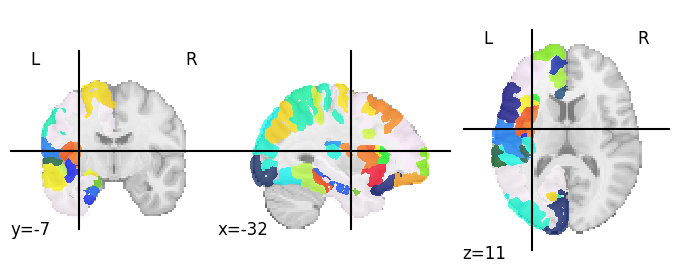

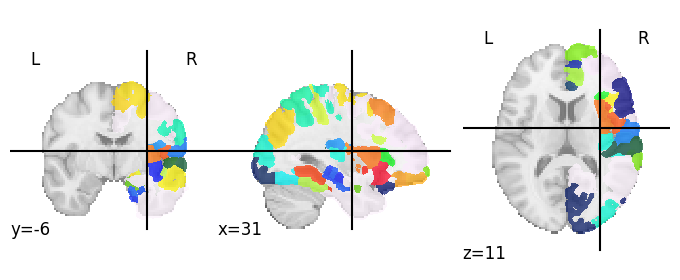

In [9]:
from nilearn import plotting
for img in jubrain_mpm.fetch_iter():
    nilearn.plotting.plot_roi(img)

### 2.3 Understand handling of region objects and map indices in siibra

The parcellation map allows us to decode map and label indices into region objects:

In [10]:
region1 = jubrain_mpm.decode_index(mapindex=0, labelindex=10)
print(region1)

Area hOc3v (LingG) left


In [11]:
region2 = jubrain_mpm.decode_index(mapindex=1, labelindex=10)
print(region2)

Area hOc3v (LingG) right


In the very same fashion we can access the more detailed probability maps for each region, by requesting the "continuous" map type. This gives us a parcellation map with hundreds of volumetric maps, each representing one brain region:

In [12]:
jubrain_pmaps = atlas.get_map(space="mni152", maptype="continuous")

[siibra:INFO] No parcellation specified, using default 'Julich-Brain Cytoarchitectonic Maps 2.9'.
Loading spatial index for 296 continuous maps: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1551658/1551658 [00:04<00:00, 374794.39voxels/s]


Let's fetch the probability map for region2 from above and plot it:

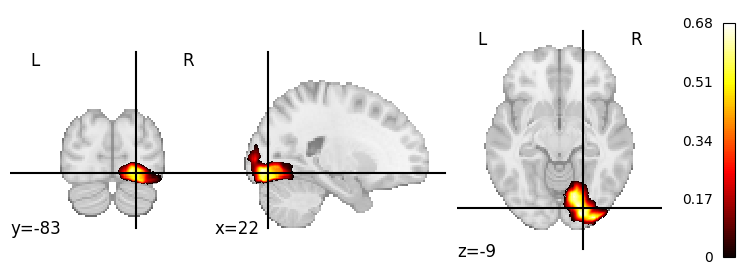

In [13]:
plotting.plot_stat_map(jubrain_pmaps.fetch_regionmap("hoc3v right"))

For the maximum probability map, the same will give us a binary mask of that region:

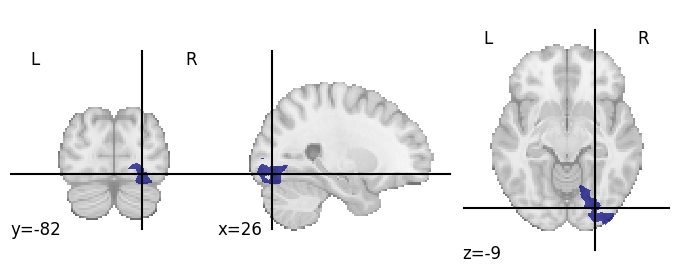

In [14]:
plotting.plot_roi(jubrain_mpm.fetch_regionmap("hoc3v right"))

## Step 3: Use Nilearn to extract signals from parcellation and functional data

In this section we use the nilearn `NiftiLabelsMasker` to extract the signals from the functional dataset and parcellation.

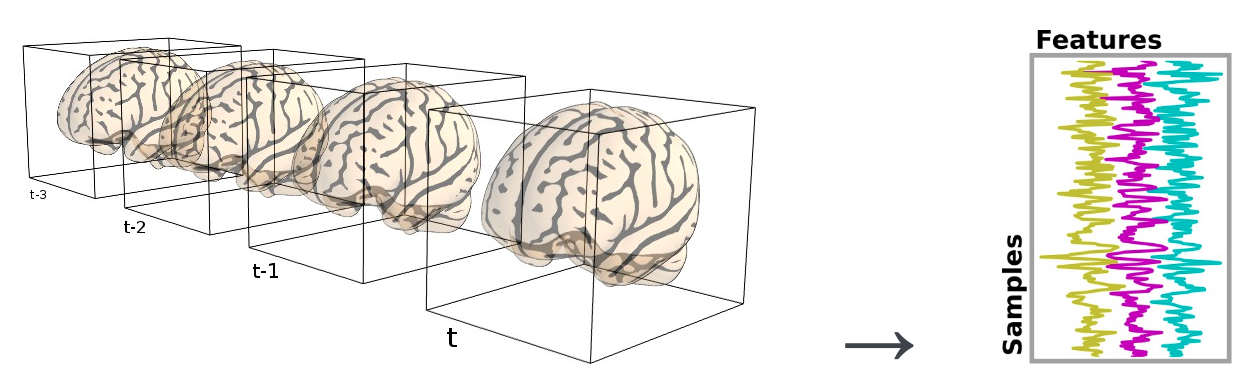

In [15]:
from IPython.display import Image
Image(filename='masker.png') 

*copyright - Image taken from the nilearn documentation.*

More information on maskers can be found in the <a href="https://nilearn.github.io/stable/manipulating_images/masker_objects.html">nilearn online documentation</a>.

For masking, we use only left hemisphere parcellation map of Julich-Brain.

The parcellation and data images have different resolutions, which will have to be handled when computing the signals:

In [16]:
parcellation_map_niimg = jubrain_pmaps.fetch()
parcellation_map_niimg.affine

array([[   1.,    0.,    0.,  -96.],
       [   0.,    1.,    0., -132.],
       [   0.,    0.,    1.,  -78.],
       [   0.,    0.,    0.,    1.]])

In [17]:
from nilearn.image import load_img
load_img(data['func'][0]).affine

In [ ]:
from nilearn.input_data import NiftiMapsMasker
import numpy as np

masker = NiftiMapsMasker(maps_img = parcellation_map_niimg,
                         resampling_target="data", # Default value
                         standardize=True, # Standardize the signals
                         memory='nilearn_cache',
                         verbose=5)
time_series = masker.fit_transform(data['func'][0], confounds=data['confounds'][0])

#time_series = np.array(time_series)
time_series.shape

[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image(
shape=(193, 229, 193),
affine=array([[   1.,    0.,    0.,  -96.],
       [   0.,    1.,    0., -132.],
       [   0.,    0.,    1.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/home/yasmin/nilearn/EBRAINS-Connectivity-Analysis/PreprocessedData_v1.0/sub-01/sub-01_ses-14_task-RestingState_dir-ap_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
<nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x7f192539b940>, { 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'low_pass': None,
  'maps_img': <nibabel.nifti1.Nifti1Image object at 0x7f192539b1f0>,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,


We have **147** standardized time series of length **168** per subject (**1** subject was loaded).

We can plot them if needed:

In [ ]:
import matplotlib.pyplot as plt

labels = list(jubrain_pmaps.regions.values())
subject_id = 0
fig = plt.figure(figsize=(12,4))
for i in [0,1,2]:
    plt.plot(time_series[subject_id, :, i],
             label=f"{labels[i]:30.30}")
plt.legend()
plt.xlim((0, 168))
plt.xlabel("Time", fontsize=15)
plt.title(f"Signals for subject {subject_id} for three regions", fontsize=15)
plt.tight_layout()

We can also generate an HTML report and visualize some components of the NiftiMapsMasker:

In [ ]:
report = masker.generate_report(displayed_maps=[2, 6, 7, 16, 21])
report

## Step 4: Use Nilearn to compute a connectivity matrix

Here we compute the correlation between these time series:

In [ ]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform(time_series)
#assert correlation_matrix.shape == (n_subj, len(labels), len(labels))

In order to visualize this matrix, we take the mean accross subject:

In [ ]:
mean_correlation_matrix = correlation_measure.mean_
#assert mean_correlation_matrix.shape == (len(labels), len(labels))

## Step 5: Use nilearn to visualize the connectivity

We can use **Nilearn** to visualize the connectivity, either as a matrix or as a graph:

### As a matrix

We can plot the matrix with the region names:

In [ ]:
mean_correlation_matrix.shape, len(labels)

In [ ]:
from nilearn.plotting import plot_matrix
# Mask the main diagonal for visualization:
np.fill_diagonal(mean_correlation_matrix, 0)
# matrices are ordered for block-like representation
# For readability show only first 40 labels
start = 0
end = 40
plot_matrix(mean_correlation_matrix[start:end, start:end],
            figure=(16, 16),
            labels=labels[start:end],
            reorder=True)

### As a graph

In [ ]:
from nilearn.plotting import plot_connectome, find_parcellation_cut_coords

# grab center coordinates for atlas labels
# !!!!! UGLY HACK ALERT !!!!!
# I'm passing the resampled label image from the masker to avoid shape errors
coordinates = find_parcellation_cut_coords(labels_img=masker._resampled_labels_img_)
# plot connectome with 95% edge strength in the connectivity
plot_connectome(mean_correlation_matrix, 
                coordinates,
                edge_threshold="95%")

## Step 6: Upload the results back to ebrains

**TODOS:**

- Decide on a representation of the connectivity results
- Find how these results could be uploaded

In [ ]:
from siibra.features.connectivity import ConnectivityMatrix

In [ ]:
m = ConnectivityMatrix(parcellation_map_niimg, 
                       mean_correlation_matrix, 
                       names, 
                       None, None) # What are these?

In [ ]:
m.parcellation

In [ ]:
mean_correlation_matrix.shape, len(labels)

In [ ]:
from nilearn.plotting import plot_matrix
# Mask the main diagonal for visualization:
np.fill_diagonal(mean_correlation_matrix, 0)
# matrices are ordered for block-like representation
# For readability show only first 40 labels
start = 0
end = 40
plot_matrix(mean_correlation_matrix[start:end, start:end],
            figure=(16, 16),
            labels=labels[start:end],
            reorder=True)

### As a graph

In [ ]:
from nilearn.plotting import plot_connectome, find_parcellation_cut_coords

# grab center coordinates for atlas labels
# !!!!! UGLY HACK ALERT !!!!!
# I'm passing the resampled label image from the masker to avoid shape errors
coordinates = find_parcellation_cut_coords(labels_img=masker._resampled_labels_img_)
# plot connectome with 95% edge strength in the connectivity
plot_connectome(mean_correlation_matrix, 
                coordinates,
                edge_threshold="95%")

## Step 6: Upload the results back to ebrains

**TODOS:**

- Decide on a representation of the connectivity results
- Find how these results could be uploaded

In [ ]:
from siibra.features.connectivity import ConnectivityMatrix

In [ ]:
m = ConnectivityMatrix(parcellation_map_niimg, 
                       mean_correlation_matrix, 
                       names, 
                       None, None) # What are these?

In [ ]:
m.parcellation